In [1]:
import xarray as xr
import numpy as np
import gsw
from sklearn.cluster import KMeans, OPTICS, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import os



In [ ]:
# # # Use Distributed dask if available
# cluster = SLURMCluster(
#     cores = 128,
#     memory = '192GB',
#     processes=1,
#     walltime='12:00:00'
# )
# cluster.scale(jobs=5)
# client = Client(cluster)

In [2]:
datapath = '/lus/scratch/shao/data/NEP36_extremes/'
ds = xr.open_mfdataset(
    f'{datapath}/processed/daily/by_year/*.nc',
    parallel=True,
    engine='h5netcdf'
)

In [3]:
# Apply various mask
mask_ds = xr.open_dataset(f'{datapath}/processed/static/mask.nc')
mask = ((mask_ds.mask[0,:,:].squeeze()>0.) &
        (ds['S'][0,:,:]>0.))
ds = ds.where(mask)

In [4]:
# Create climatology
ds_clim = ds.mean('time')
ds_std = ds.std('time')

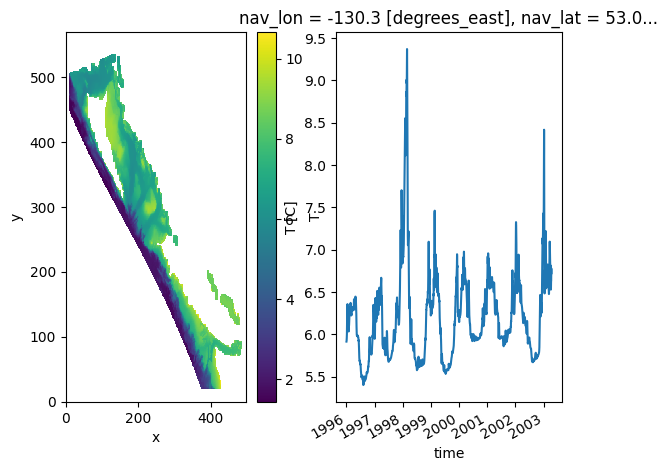

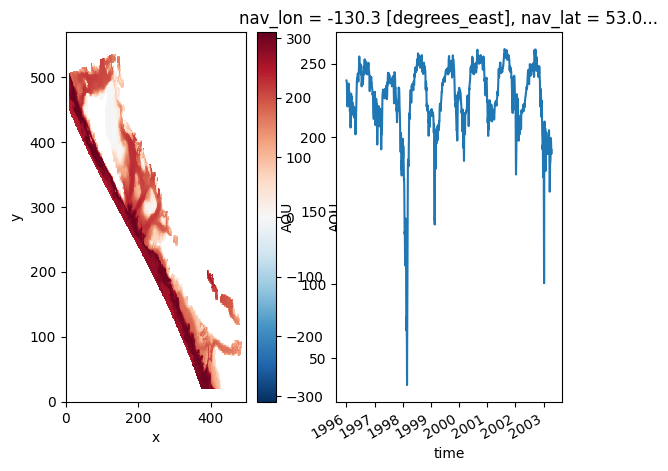

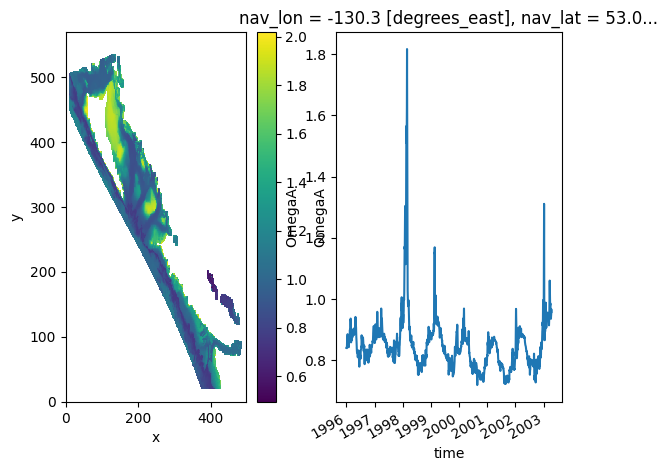

In [5]:
for var in ['T', 'AOU', 'OmegaA']:
    plt.figure()
    plt.subplot(1,2,1)
    ds_clim[var].plot()
    plt.subplot(1,2,2)
    ds[var].isel(x=175,y=400).plot()

In [6]:
# Convert to feature array
features = np.array([
    ds_clim.OmegaA.to_numpy().flatten(),
    ds_clim.AOU.to_numpy().flatten(),
    ds_clim.T.to_numpy().flatten(),
    # ds_clim.depths.to_numpy().flatten(),
    # ds_std.OmegaA.to_numpy().flatten(),
    # ds_std.AOU.to_numpy().flatten(),
    # ds_std.T.to_numpy().flatten(),
])

In [7]:
# Mask the feature array
mask_vec = mask.to_numpy().flatten() > 0.
features_masked = features[:,mask_vec]
mask_masked     = mask_vec[mask_vec]
features_masked = features_masked.transpose()

In [8]:
# Scale the features
scaler = StandardScaler()
scaler.fit(features_masked)
scaled_features = scaler.transform(features_masked)

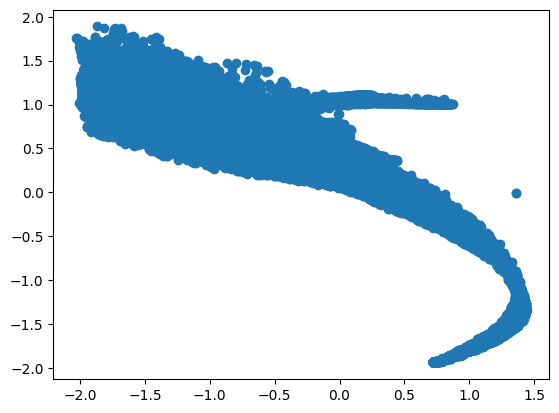

In [9]:
plt.scatter(scaled_features[:,1], scaled_features[:,2])

In [10]:
print(scaler.n_features_in_, scaler.n_samples_seen_)

3 53344


In [11]:
scaled_features.shape

(53344, 3)

In [12]:
# Perform the clustering
n_clusters = 8
kmeans_region = KMeans(    
    n_clusters = n_clusters,
    n_init = 10
)
kmeans_region.fit(scaled_features)
cluster_id = np.zeros(features.shape[1])*np.nan
cluster_id[mask_vec] = kmeans_region.labels_
cluster_id = cluster_id.reshape(ds_clim.DIC.shape)
ds_clim['cluster'] = (('y','x'),cluster_id)

In [13]:
ds_clim

<xarray.Dataset>
Dimensions:  (y: 570, x: 498)
Coordinates:
    nav_lon  (y, x) float32 dask.array<chunksize=(570, 498), meta=np.ndarray>
    nav_lat  (y, x) float32 dask.array<chunksize=(570, 498), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    ALK      (y, x) float32 dask.array<chunksize=(570, 498), meta=np.ndarray>
    AOU      (y, x) float64 dask.array<chunksize=(570, 498), meta=np.ndarray>
    DIC      (y, x) float32 dask.array<chunksize=(570, 498), meta=np.ndarray>
    NO3      (y, x) float32 dask.array<chunksize=(570, 498), meta=np.ndarray>
    O2       (y, x) float32 dask.array<chunksize=(570, 498), meta=np.ndarray>
    OmegaA   (y, x) float64 dask.array<chunksize=(570, 498), meta=np.ndarray>
    S        (y, x) float32 dask.array<chunksize=(570, 498), meta=np.ndarray>
    T        (y, x) float32 dask.array<chunksize=(570, 498), meta=np.ndarray>
    depths   (y, x) float64 dask.array<chunksize=(570, 498), meta=np.ndarray>
    cluster  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

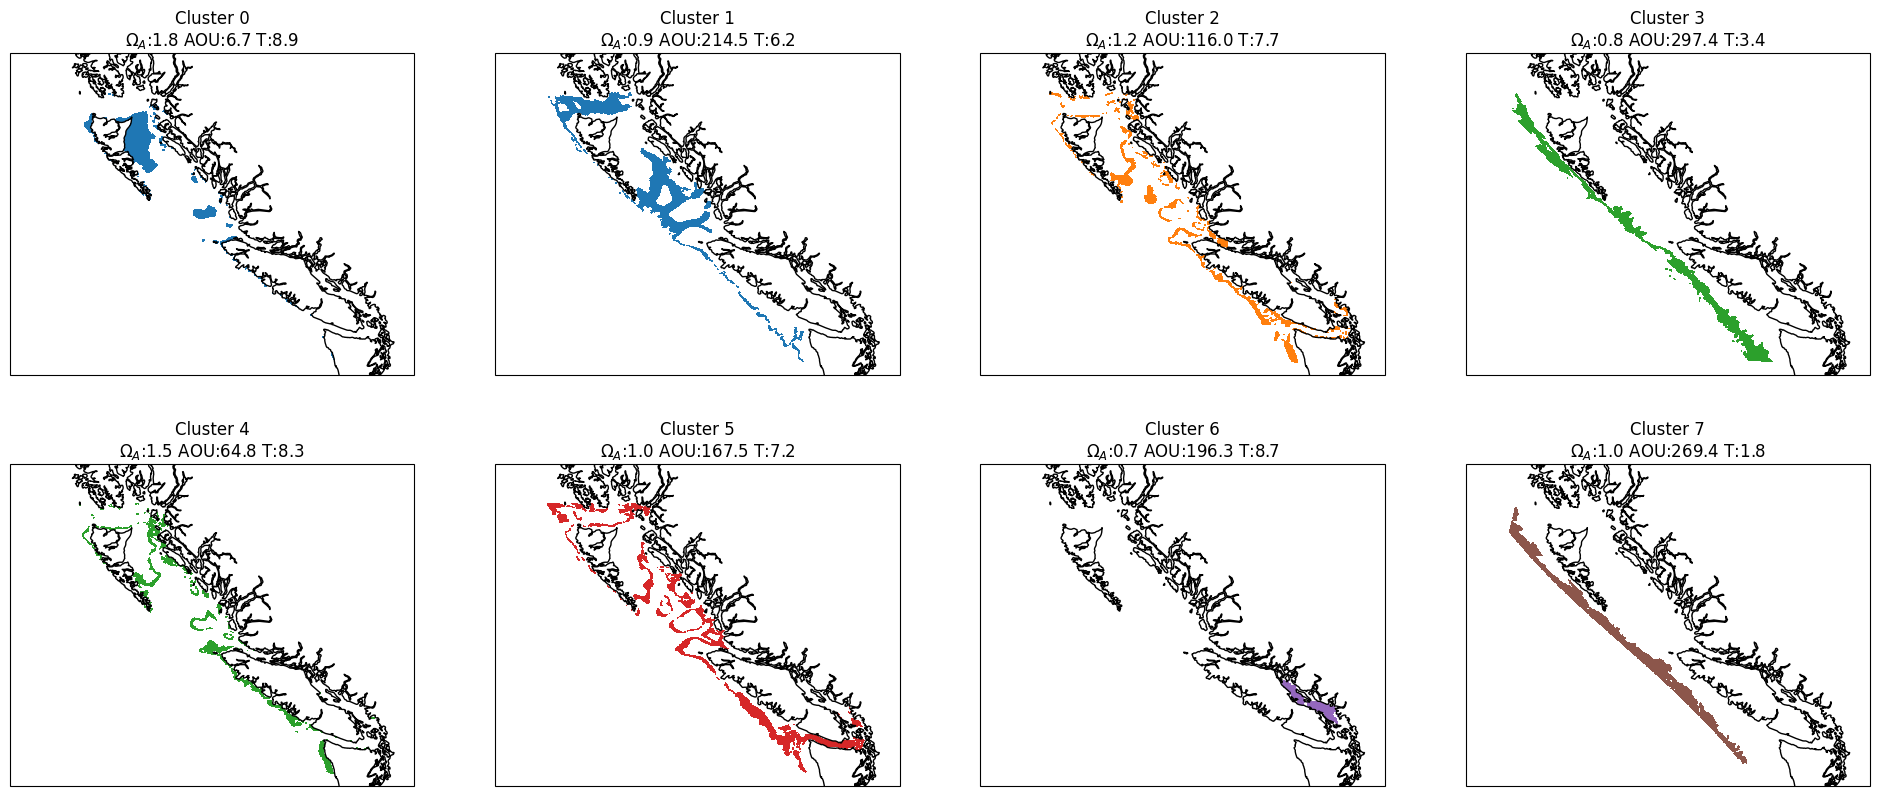

In [14]:
extent = [ds.nav_lon.min(), ds.nav_lon.max(), ds.nav_lat.min(), ds.nav_lat.max()]

plt.figure(figsize=(24,24))
colors = [plt.cm.tab10(i) for i in range(n_clusters)]
for i in range(n_clusters):
    ax = plt.subplot(3,4,i+1,projection=ccrs.Miller())
    ds_clim.cluster.where(ds_clim.cluster==i).plot.contourf(
        x='nav_lon',
        y='nav_lat',
        vmin=0,
        vmax=n_clusters,
        colors=colors,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    center = scaler.inverse_transform(kmeans_region.cluster_centers_[i,:].reshape(1,-1))[0]
    plt.title(f'Cluster {i}\n$\Omega_A$:{center[0]:.1f} AOU:{center[1]:.1f} T:{center[2]:.1f}')
    # plt.title(f'Cluster {i}')
    ax.coastlines()
    ax.set_extent(extent)
plt.subplots_adjust(hspace=-0.6)

In [15]:
ds_clim.to_netcdf(f'{datapath}/processed/clim/clim_with_clusters.nc')

In [57]:
optics_region

OPTICS()

In [59]:
scaled_features.shape

(6, 41550)